In [1]:
import pandas as pd
import numpy as np
import itertools as it

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_4412\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Мы знаем, как рассчитать необходимый объём выборок. Теперь нужно правильно выбрать пользователей для эксперимента.

## A/A-тесты
* A/A-тест помогает удостовериться в том, что разделение выборок происходит корректно
* Позволяет определить уровень значимости для A/B-теста
* В целом проверяет надёжность работы системы тестов

Нулевая и альтернативная гипотезы берутся такие же как для A/B теста. Возьмём контрольную группу из датасета cookie cats с прошлой лекции на роль исторических данных.

In [3]:
data = pd.read_csv("../data/cookie_cats.csv")
data = data[data['version'] == 'gate_30'].drop(columns=['version']).reset_index(drop=True)
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
data

,userid,sum_gamerounds,retention_1,retention_7
0,116,3,False,False
1,337,38,True,False
2,1066,0,False,False
3,2101,0,False,False
4,2179,39,True,False
...,...,...,...,...
44695,9998576,14,True,False
44696,9998623,7,False,False
44697,9999178,21,True,False
44698,9999349,10,False,False


Разобьём пользователей на группы, как сделали бы, готовя проведение A/B-тестирования

In [4]:
a1 = data.sample(frac = 0.55)
a2 = data.drop(a1.index)

len(a1), len(a2)

(24584, 20115)

Если у нас есть представления о том, какое разбиение хотелось получить, и неизвестно, какое получено в реальности, можно выполнить проверку на SRM — Sample Rate Mismatch, отклонение фактического разбиения от ожидаемого. Здесь приведён [$\chi^2$-критерий](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%85%D0%B8-%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82). Если p-value *достаточно близко к 1*, разбиение не соответствует ожидаемому и нужно его переделать, чтобы правильно провести эксперимент.

In [8]:
from scipy.stats import chisquare

chi = chisquare([len(a1), len(a2)], f_exp = [24600, 20099])
chi

Power_divergenceResult(statistic=0.02314345615220917, pvalue=0.8790846123238008)

In [9]:
print("Разбиение достаточно близко к желаемому") if chi.pvalue < 0.95 else print("Разбиение сильно отдичается от желаемого")

Разбиение достаточно близко к желаемому


Бутстрап: делаем множество разбиений и для каждого проводим t-test

In [10]:
from scipy.stats import ttest_ind
from tqdm import tqdm

p_values = []

for a in tqdm(range(10000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    p_values.append(test.pvalue)

100%|██████████| 10000/10000 [07:28<00:00, 22.31it/s]


Text(0.5, 0, 'P-value')

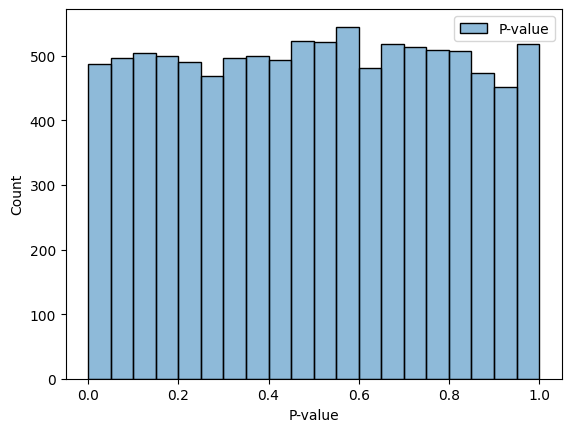

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=pd.DataFrame(p_values, columns=['P-value']), bins=20)
plt.xlabel("P-value")

Для заключения об успехе A/A теста полученное распределение полученных p-значений должно быть равномерным. Для проверки равномерности используем критерий Колмогорова-Смирнова

In [12]:
from scipy.stats import kstest

ks = kstest(p_values,"uniform")
ks

KstestResult(statistic=0.007731814913774615, pvalue=0.5855626711441715, statistic_location=0.8199681850862254, statistic_sign=1)

In [13]:
print("Распределение равномерно") if ks.pvalue > 0.05 else print("Распределение не равномерно")

Распределение равномерно


In [27]:
for i in tqdm(range(1000)):
    a1 = data.sample(frac = 0.55)
    a2 = data.drop(a1.index)
    test = ttest_ind(a1['sum_gamerounds'], a2['sum_gamerounds'], equal_var=False)
    if (test.pvalue < 0.05):
        break

  2%|▏         | 20/1000 [00:01<01:17, 12.61it/s]


In [28]:
test

TtestResult(statistic=2.2872953829076073, pvalue=0.022183264449541377, df=44446.35214171891)

Нашли разбиение, для которого A/A-тест подтвердил нулевую гипотезу, можно использовать для A/B.

## A/B/C-тесты

В некоторых ситуациях может понадобиться одновременно протестировать несколько гипотез.

Эксперимент: магазин одежды отправлял клиентам почтовую рассылку с рекламой женской одежды, мужской одежды или не отправлял рассылку вообще. Будем оценивать суммы, потраченные этими пользователями на сайте за год.

In [93]:
data = pd.read_csv("../data/MineThatData.csv")
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail
...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail


Рассмотрим только группы новых клиентов

In [94]:
data = data[data.newbie == 1]

In [95]:
data['segment'].value_counts()

segment
Womens E-Mail    10763
No E-Mail        10695
Mens E-Mail      10686
Name: count, dtype: int64

In [99]:
data = data[['segment', 'history']]
data

,segment,history
1,No E-Mail,329.08
2,Womens E-Mail,180.65
3,Mens E-Mail,675.83
6,Womens E-Mail,280.20
8,Mens E-Mail,675.07
...,...,...
63991,Womens E-Mail,306.10
63992,Mens E-Mail,519.69
63996,Mens E-Mail,38.91
63997,Mens E-Mail,29.99


In [102]:
data.groupby('segment').history.mean()

segment
Mens E-Mail      301.214606
No E-Mail        297.121581
Womens E-Mail    298.737283
Name: history, dtype: float64

Растёт вероятность ошибки для независимых p-value, поэтому поднимается уровень значимости (false positive): $1 - (1 - \alpha)^n$, где n для A/B/.../N теста $n=\binom{N}{2}$

In [114]:
# слишком высокая альфа для настоящего эксперимента
alpha = 0.1
1 - (1 - alpha) ** 3

0.2709999999999999

Поправка Бонферрони: $\alpha* = \frac{\alpha}{n}$

In [115]:
bonferroni_alpha = alpha / 3
bonferroni_alpha

0.03333333333333333

Поправка Бенджамини-Хохберга:<br>
1. Сортируем p-значения по возрастанию и присваиваем им индексы<br>
$p_1\leq p_2\leq ...\leq p_n$<br>
2. Находим p с наибольшим рангом $j*$ такое, что:<br>
$p_j\leq q$; $q = \gamma \frac{j}{n}$<br>
3. Все тесты с рангом $j < j*$ — статзначимые

Сравним результаты с двумя этими поправками.

In [39]:
from scipy import stats

In [117]:
def p(col1, col2):
    return stats.ttest_ind(
        data[data.segment == col1].history.reset_index(drop=True),
        data[data.segment == col2].history.reset_index(drop=True), equal_var=False).pvalue

gamma = 0.1
segments = data.segment.unique()
df = pd.DataFrame(np.array(list(it.combinations(segments, 2))), columns=['seg1', 'seg2'])
df['p'] = df.apply(lambda x: p(x['seg1'], x['seg2']), axis=1)
df = df.sort_values(by=['p'])
df['q'] = gamma * (df.index + 1) / len(df)
df['p_corrected_BH'] = gamma * df['p'] ** len(df) / df['q']
df['BH'] = df['p_corrected_BH'] < alpha
df['bonferroni'] = df['p'] < bonferroni_alpha
df

,seg1,seg2,p,q,p_corrected_BH,BH,bonferroni
1,No E-Mail,Mens E-Mail,0.360055,0.066667,0.070016,True,False
2,Womens E-Mail,Mens E-Mail,0.580809,0.100000,0.195929,False,False
0,No E-Mail,Womens E-Mail,0.714052,0.033333,1.092221,False,False
